# Исследование гипотез для увеличения  выручки интернет-магазина

В распроряжении аналитического и маркетингового отделов данные о гипотезах, поведении клиентов и группах A/B-теста для выработки стратегий повышения выручки.  


# Цель, задача и алгоритм действий

Данное исследование направлено на проверку гипотез, в частности, их приоритизацию, с целью выявления закономерностей в поведении клиентов. Планируется, что полученные результаты позволят интернет-магазину скорретировать маркетинговую стратегию и, как следствие, увеличить свою выручку. 

**Анализ будет проведен по следующему алгоритму:**

    -Проведение предобработку данных для повышения качества исследования;
    -Приоритизация гипотез по увеличению выручки с использованием различных фреймоворков (ICE и RICE);
    -Расчет кумулятивных пользовательских метрик по группам, в частности среднего чека, средней выручки и среднего 
    количества заказов;
    -Построение графиков кумулятивных пользовательских метрик;
    -Построение графиков отношения кумулятивных пользовательских метрик группы B к группе A;
    -Пасчет статистической значимости различий средних пользовательских метрик (среднего чека, средней выручки и 
    среднего  количества заказов) до исследования аномалий;
    -Выявление аномальных значений при помощи гистограмм и точечных графиков;
    -Расчет 95-го и 99-го перцентиля количества заказов на пользователя и стоимости заказов;
    -Очищение данных от аномалий;
    -Построение графиков кумулятивных пользовательских метрик после фильтрации данных;
    -Вычисление статистической значимости различий средних показателей пользовательского поведения после фильтрации
    данных для того, чтобы оценить степень успешности A/B-теста. 



# Шаг 1. Открытие файлов с данными и предобработка данных

In [1]:
import pandas as pd #импортируем бибилиотеку pandas для работы с датафреймом
pd.set_option('display.max_colwidth', 0)
from scipy import stats as st# импортируем библиотеку scipy для статистического анализа
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
import matplotlib.pyplot as plt #импортируем библиотеку matpolib.byplot для того, чтобы в дальейшем присваивать осям и самим графикам названиям
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('hypothesis.csv')

In [3]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('visitors.csv')
    


In [4]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('orders.csv')

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


**Приведем к нижнему регистру названия столбцов в датафрейме.**

In [6]:
hypothesis.columns = map(str.lower, hypothesis.columns)

**Выведем на экран все гипотезы.**

In [7]:
hypothesis.hypothesis.unique()

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Изменим тип данных в столбце с датой.**

In [9]:
visitors['date']= pd.to_datetime(visitors['date'])


**Выведем первые 5 строк датафрейма.**

In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Проверим, повторяются ли в нем строки.**

In [11]:
print('Число дубликатов:', visitors.duplicated().sum())

Число дубликатов: 0


**Теперь перейдем к датафрейму с информацией о заказах.**

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


**Немного изменим названиия столбцов, добавив нижние подчеркивания.**

In [13]:
orders.columns = [
    'order_id',
    'user_id',
    'date',
    'revenue',
    'group'
]

**По аналогии со столбцом date датафрейма visitors изменим тип данных столбца с датой заказа.**

In [14]:
orders['date']= pd.to_datetime(orders['date'])

**Выведем на экран первые 5 строк датафрейма.**

In [15]:
orders.head()

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**Посмотрим, есть ли случаи, когда один и тот же пользователь сразу в двух группах.**

**Такие пользователи есть.**

In [16]:
duplicates = orders.groupby('user_id').agg({'group':'nunique'}).query('group > 1')
len(duplicates)

58

**Прежде чем удалять этих пользователей, нужно посмотреть, на какую сумму они сделали покупки.**

**Пользователи, которые относятся к обеим группам, принесли компании 1 млн. 558 тыс. рублей.**

In [17]:
duplicates_revenue = orders.query('user_id in @duplicates.index')

revenue_duplicates = duplicates_revenue['revenue'].sum()

**Теперь посмотрим общую выручку.**

**Она составляет 9 млн. 992 тыс. рублей.**

In [18]:
revenue_total = orders['revenue'].sum()

**На пользователей, которые относятся сразу к двум группам, приходится 15.6% всей выручки. Удалив их из датафрейма, мы рискуем исказить данные, что может повлечь за собой неправильную трактовку результа теста.**

In [19]:
revenue_duplicates * 100 / revenue_total


15.600952428320943

## Приоритизация гипотез

### Применение фреймворка ICE

**Первым для приоритизации 9 гипотез применим фреймворк ICE. Следуя данной методике, мы будем учитывать отношение произведения показателя влияния продукта на пользователя (impact) и увереннности в этих изменениях (confidence) к затрачиваемых на них усилиям (efforts).**

**Как видно ниже, наиболее приоритетными являются гипотезы 9, 1 и 8. Они сформулированы следующим образом:**

    -Запустить акцию, дающую скидку на товар в день рождения;
    -Добавить два новых канала привлечения канала трафика, что позволит привлекать на 30% больше пользователей;
    -Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
    

In [20]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
#добавим в датафрейм столбец с показателем ICE для каждой гиппотезы

hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)
#отсортируем столбцы со сформулированными гипотезами и их показателями ICE по столбцу ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Применение фреймворка RICE

**Теперь применим фреймворк RICE, т.е. примим во внимание для приоритизации фактор охвата изменений (reach).**

**Как видно ниже, при учете охвата восьмая и первая гипотезы остаются в топ-3 по приоритетности. Если учитывать охват, то гипотеза о запуске акции, дающей скидку на товар в день рождения, занимает лишь пятое место по приоритетности. Тройка лидеров по такому методу выглядит так:**
    
    -Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    -Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
    -Добавить два новых канала привлечения канала трафика, что позволит привлекать на 30% больше пользователей.

In [21]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
#добавим в датафрейм столбец с показателем RICE для каждой гиппотезы

hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)
#отсортируем столбцы со сформулированными гипотезами и их показателями RICE по столбцу RICE

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [22]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
#добавим в датафрейм столбец с показателем ICE для каждой гиппотезы

hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)
#отсортируем столбцы со сформулированными гипотезами и их показателями ICE по столбцу ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Изменение приоритетности гипотез связано с добавлением критерия охвата. В таком случае гипотеза об увеличении выручки вследствии предоставления скидки по случаю дня рождения становится приоритетной, потому что такое нововедение может затронуть незначительную часть клиентов. Для того, чтобы с таким изменением познакомилось большинство пользователей, A/B-тест нужно проводить как минимум 9-10 месяцев; на это требуется много ресурсов. Иная ситуация с третьей и восьмой гипотезами: все пользователи, зайдя на сайт интернет-магазина, увидят форму подписки на все главные страницы и блоки персонализированных рекомендаций. Помимо этого, увеличение каналов привлечения означает увеличение числа привлекаемых пользователей, т.е. охвата.**

**С большим отрывом по степени приоритетности лидирует гипотеза под номером 8 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Она, однако, не затрагивает вопросы выручки: как раз увеличение этого показателя является первостепенной маркетингового отдела.Значит,мы не можем для А/В-теста выбрать ее. Отдадим предпочтение гипотезе номер 3 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". Как раз она подходит под наши цели.**

## Анализ A/B-теста

**Cначала проверим количеством групп тестирования в обоих датафреймах.**

In [23]:
print('Уникальные группы теста:', visitors.group.unique())

Уникальные группы теста: ['A' 'B']


In [24]:
print('Уникальные группы теста:', orders.group.unique())

Уникальные группы теста: ['B' 'A']


### Кумулятивная выручка по группам

**Сначала создадим массив уникальных пар значений дат и групп теста.**

In [25]:
datesGroups = orders[['date','group']].drop_duplicates()


**Затем соберём агрегированные кумулятивные по дням данные о заказах и посещениях интернет-магазина.**

In [26]:
ordersAggregated = datesGroups.apply( #агрегируем данные по дате совершения заказов
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max', 
            'order_id': 'nunique', #находим число заказов за день 
            'user_id': 'nunique', #находим число пользователей, совершивших заказ
            'revenue': 'sum', #находим выручку за день
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


visitorsAggregated = datesGroups.apply( #агрегируем данные по дате посещения интернет-магазина
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
          'date':'max',
        'group':'max',
        'visitors':'sum' #находим количество посетителей интернеит-магазина за день  
        }
    ),
    axis=1,
).sort_values(by=['date','group'])


**Выведем на экран первые 5 строк датафреймов с кумулятивными данными.**

In [27]:
ordersAggregated.head()

,date,group,order_id,user_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [28]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


**Теперь соединим таблицы.**

In [29]:
cumulative_data = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])


In [30]:
cumulative_data.head()

,date,group,order_id,user_id,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


**Переименуем названия столбцов для удобства.**

In [31]:
cumulative_data.columns = [
    'date',
    'group',
    'order_count',
    'buyer_count',
    'revenue_total',
    'users_total'
]



**Переходим к построению графика.**

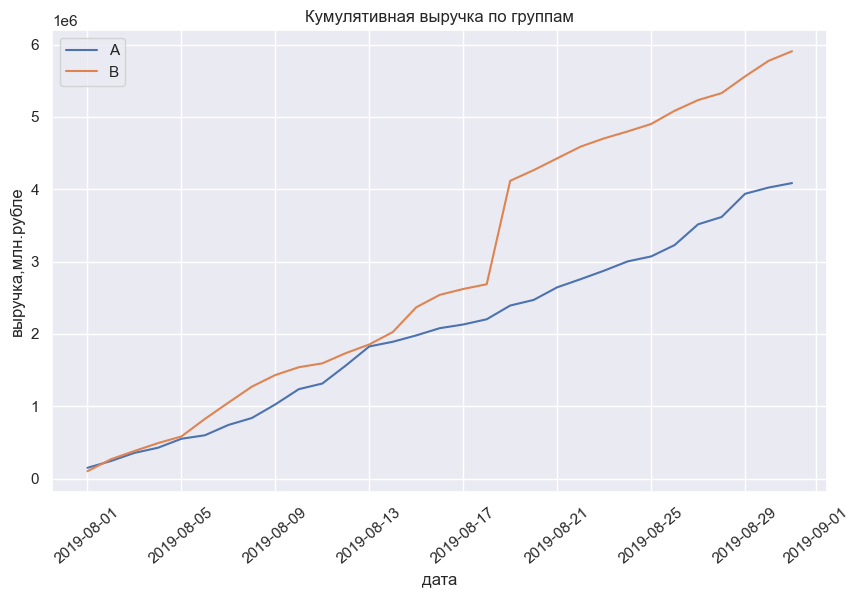

In [32]:

cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue_total', 'order_count']]
#создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue_total', 'order_count']]
#аналогично сделаем для группы B


plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue_total'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue_total'], label='B')
plt.legend()
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('выручка,млн.рубле')
plt.title('Кумулятивная выручка по группам');

**Как видно ниже, на протяжении первых дней показатели показатели выручки у обеих групп почти совпадали. Затем выручка от пользователей из группы B стала расти. 13 августа показатели группы A выровнялся с группой B. В обеих группах продолжся рост выручки на протяжении всего исследуемого периода, однако, стоит отметить, что от группы B впоследние 10 дней она была существенно больше, чем от группы  A. Также примерно 17 августа резко выросла выручка от пользователей из группы B: резкий рост мог быть вызван покупкой на большую сумму одним или нескольким покупателем.Будем дальше с этим разбираться.** 

### Кумулятивный средний чек по группам

**Для построения графика с такой информацией разделим выручку на количество заказов.**

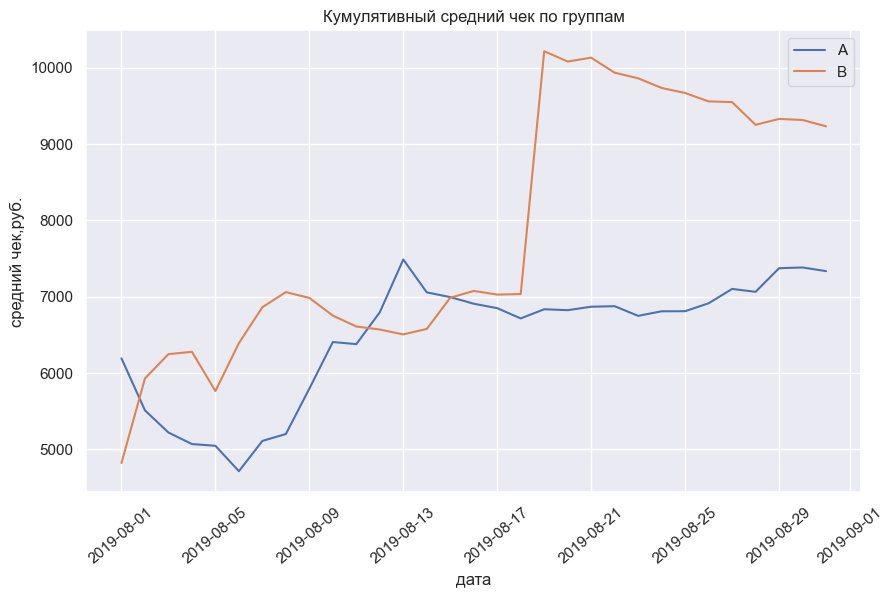

In [33]:
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue_total']/cumulative_revenueA['order_count'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue_total']/cumulative_revenueB['order_count'], label='B')
plt.legend()
plt.xticks(rotation = 40)
plt.xlabel('дата')
plt.ylabel('средний чек,руб.')
plt.title('Кумулятивный средний чек по группам');

**В обеих группах средний чек не был стабильным: на графике заметны скачки. В случае группы A резкое повышение среднего чека произошло после его снижения на протяжении первых дней исследования.В случае группы B стремительный рост произошел в те же дни, когда была самая высокая выручка.Видимо, были совершены очень крупные заказы, которые исказили реальный средний чек. Поскольку аномально высокие значения искажают картину пользовательского поведения, их нужно  удалить.**

### Относительное изменение кумулятивного среднего чека группы B к группе A

**Сначала объединим датафрейм с показателями выручки.**

In [34]:
merged_сumulative_revenue = cumulative_revenueA.merge(
    cumulative_revenueB, left_on = ['date'], right_on = ['date'], how='left', suffixes=['A', 'B']
)

In [35]:
merged_сumulative_revenue.head()

,date,revenue_totalA,order_countA,revenue_totalB,order_countB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


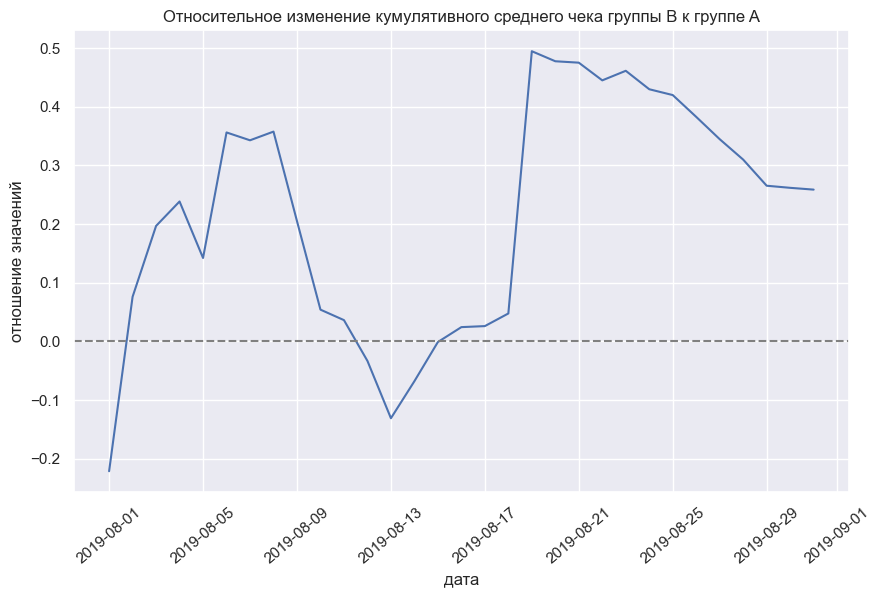

In [36]:
plt.plot(merged_сumulative_revenue['date'], (merged_сumulative_revenue['revenue_totalB'] /merged_сumulative_revenue['order_countB'])/(merged_сumulative_revenue['revenue_totalA']/merged_сumulative_revenue['order_countA'])-1)

plt.axhline(y=0,color='grey', linestyle='--')
plt.xticks(rotation = 40)
plt.xlabel('дата')
plt.ylabel('отношение значений')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A');

**Как видно на графике, отношение кумулятивного среднего чека группы B к группе А не было постоянным несмотря на общую тенденцию его увеличения. В первые дни августа средний чек группы B был более чем на 20% больше, чем у группы A. В начале второй недели месяца произошел резкий рост кумулятивного среднего чека в группе B, что выражается в росте его отношения к чеку группы A. Это ,как было подчеркнуто выше, связано не с увеличением объема продаж а с большими тратами со стороны пользователей. 8 августа отношений начало снижаться, в связи с чем примерно с 12 по 15 августа отношение было отрицательным. Резкий рост отношения во второй половины месяца указывает на крупные заказы среди пользователей группы B.**  

**Сначала получим кумулятивные значения количества заказов в каждый день в группах. Для этого объявим переменные orders_cummulativeA и orders_cummulativeB.**

In [37]:
visitors_dailyA = visitors[visitors['group'] == 'A'][['date', 'visitors']] #создадим датафрейм с количеством посещений в день в группе А
visitors_dailyA.columns = ['date', 'visitorsPerDateA'] 

visitors_cummulative_A = visitors_dailyA.apply(
    lambda x: visitors_dailyA[visitors_dailyA['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_A.columns = ['date', 'visitors_cummulativeA']


orders_dailyA = ( #создадим датафрейм с количеством закзаов в день в группе А
    orders[orders['group'] == 'A'][['date', 'order_id', 'user_id']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_dailyA.columns = ['date', 'ordersPerDateA']

orders_cummulativeA = orders_dailyA.apply(
    lambda x: orders_dailyA[orders_dailyA['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulativeA.columns = [
    'date',
    'orders_cummulativeA'
]




**Выведем на экран первые 5 строк датафрейма orders_cummulativeA, содержащего информацию о количестве заказов в день в группе A.**

In [38]:
orders_cummulativeA.head()

,date,orders_cummulativeA
0,2019-08-01,24
1,2019-08-02,44
2,2019-08-03,68
3,2019-08-04,84
4,2019-08-05,109


In [39]:
visitors_dailyB = visitors[visitors['group'] == 'B'][['date', 'visitors']] #создадим датафрейм с количеством посещений в день в группе B
visitors_dailyB.columns = ['date', 'visitorsPerDateB']

visitors_cummulativeB = visitors_dailyB.apply(
    lambda x: visitors_dailyB[visitors_dailyB['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitors_cummulativeB.columns = ['date', 'visitors_cummulativeB']

orders_dailyB = (   #создадим датафрейм с количеством закзаов в день в группе B
    orders[orders['group'] == 'B'][['date', 'order_id', 'user_id']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_dailyA.columns = ['date', 'ordersPerDateB']

orders_cummulativeB = orders_dailyB.apply(
    lambda x: orders_dailyA[orders_dailyA['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulativeB.columns = [
    'date',
    'orders_cummulativeB'
]


**Напишем аналогичный код для того, чтобы получить датафрейм с количеством заказов в день в группе B.**

**По аналогии с группой A выведем первые 5 строк датафрейма с данными группы B.**

In [40]:
orders_cummulativeB.head()

,date,orders_cummulativeB
0,2019-08-01,24
1,2019-08-02,44
2,2019-08-03,68
3,2019-08-04,84
4,2019-08-05,109


**Теперь объединим полученные датафреймы.**

### Кумулятивное среднее количество заказов на посетителя 

**Добавим столбец со значением среднего количества заказов на посетителя.**

In [41]:
cumulative_data['order_count_per_user'] = cumulative_data['order_count'] / cumulative_data['users_total']

**Построим график, ссылаясь на данные переменные.**

In [42]:
cumulative_dataA = cumulative_data[cumulative_data['group'] == 'A']
cumulative_dataB = cumulative_data[cumulative_data['group'] == 'B']

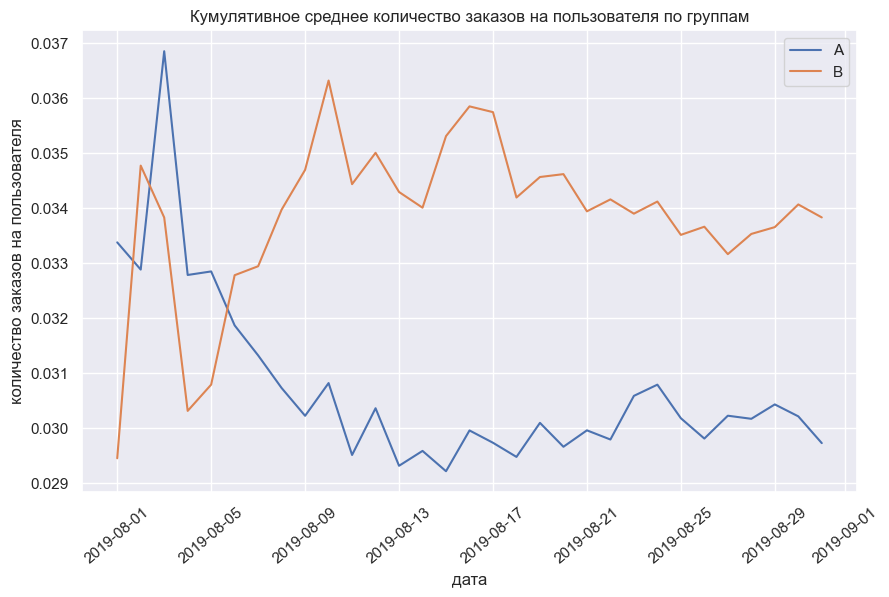

In [43]:
plt.plot(cumulative_dataA['date'], cumulative_dataA['order_count_per_user'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['order_count_per_user'], label='B')
plt.legend()
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('количество заказов на пользователя')
plt.title('Кумулятивное среднее количество заказов на пользователя по группам');

**На графике видно, что на протяжении первой недели теста группа A лидировала по среднему количеству заказов на пользователя по группам: на пике разница составляла  около 0.03 %.  Скорее всего, имеют место выбросы в группе А. 5 августа показатели среднего количества заказов на пользователи у групп выравнились,и вслед за этим группа B вырвалась вперед.**

**Объединим датафреймы cumulative_dataA и cumulative_dataB. Выведем   первые 5 строк.**

In [44]:
mergedOrderCountPerUser = cumulative_dataA[['date', 'order_count_per_user']].merge(
    cumulative_dataB[['date','order_count_per_user']], left_on = ['date'], right_on = ['date'], how='left', suffixes=['A', 'B']
)
mergedOrderCountPerUser.head()

,date,order_count_per_userA,order_count_per_userB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


**Построим график.**

**На протяжении первой недели теста отношение кумулятивного среднего чека количества заказовт на посетителя B к группе A было отрицательным.  Затем отношение резко (за 4 дня) изменилось: теперь оно стало положительным в пользу группы B. Оно достигло своего пика в середине теста: оно составило 20%. В целом, несмотря на начальное отрицательное значение четко видно, что в группе B продажи шли лучше, чем в группе А.**




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


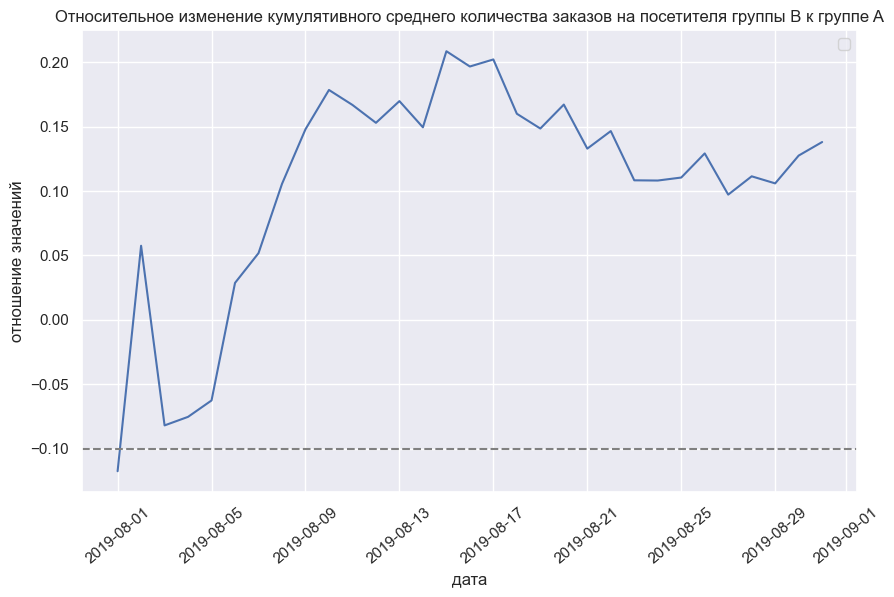

In [45]:
plt.plot(mergedOrderCountPerUser['date'], mergedOrderCountPerUser['order_count_per_userB']/mergedOrderCountPerUser['order_count_per_userA']-1)
plt.legend()
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation = 40)
plt.xlabel('дата')
plt.ylabel('отношение значений')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A');

**После анализа визуализаций объединим данные кумулятивные метрики. Это пригодится при расчете статистических значимостей различий.**

In [46]:
merged_data = (
    visitors_dailyA.merge(
        visitors_dailyB, left_on ='date', right_on = 'date', how='left'
    )
    .merge(visitors_cummulative_A, left_on ='date', right_on = 'date', how='left')
    .merge(visitors_cummulativeB, left_on ='date', right_on = 'date', how='left')
    .merge(orders_dailyA, left_on ='date', right_on = 'date', how='left')
    .merge(orders_dailyB, left_on ='date', right_on = 'date', how='left')
    .merge(orders_cummulativeA, left_on ='date', right_on = 'date', how='left')
    .merge(orders_cummulativeB, left_on ='date', right_on = 'date', how='left')
    
)


merged_data.head()


,date,visitorsPerDateA,visitorsPerDateB,visitors_cummulativeA,visitors_cummulativeB,ordersPerDateB,order_id,orders_cummulativeA,orders_cummulativeB
0,2019-08-01,719,713,719,713,24,21,24,24
1,2019-08-02,619,581,1338,1294,20,24,44,44
2,2019-08-03,507,509,1845,1803,24,16,68,68
3,2019-08-04,717,770,2562,2573,16,17,84,84
4,2019-08-05,756,707,3318,3280,25,23,109,109


**Для удобства переимениуем столбцы.**

In [47]:
merged_data.columns= [
    'date',
    'visitors_per_dateA',
    'visitors_per_dateB',
    'visitors_cummulativeA',
    'visitors_cummulativeB',
    'orders_per_dayB',
    'order_id',
    'orders_cummulativeA',
    'orders_cummulativeB'
]

### Точечный график количества заказов по пользователям

**Объявим переменные ordersByUsersA и OrdersbyUsersB со столбцами user_id и orders_total.**

In [48]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders_total']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders_total']

ordersByUsers = (
    orders.groupby('user_id', as_index=False)
    .agg({'order_id' : pd.Series.nunique})
)


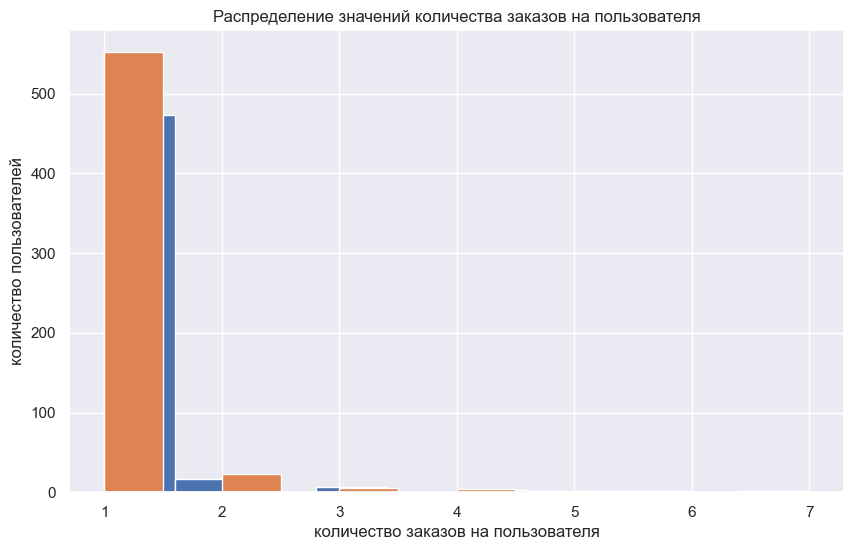

In [49]:
plt.hist(ordersByUsersA['orders_total'],label='A') 
plt.hist(ordersByUsersB['orders_total'],label='B')
plt.xlabel('количество заказов на пользователя')
plt.ylabel('количество пользователей')
plt.title('Распределение значений количества заказов на пользователя');

**В обеих группах абсолютное большинство пользователей сделали 1 заказ. Несколько десятков пользователей оформили 2 заказа. На графике видно, что есть и те, кто оформил 3-4 заказа, но таких пользователей значительно меньше.**

**Чтобы лучше ознакомиться с аномальными значениями, построим точечный график.**

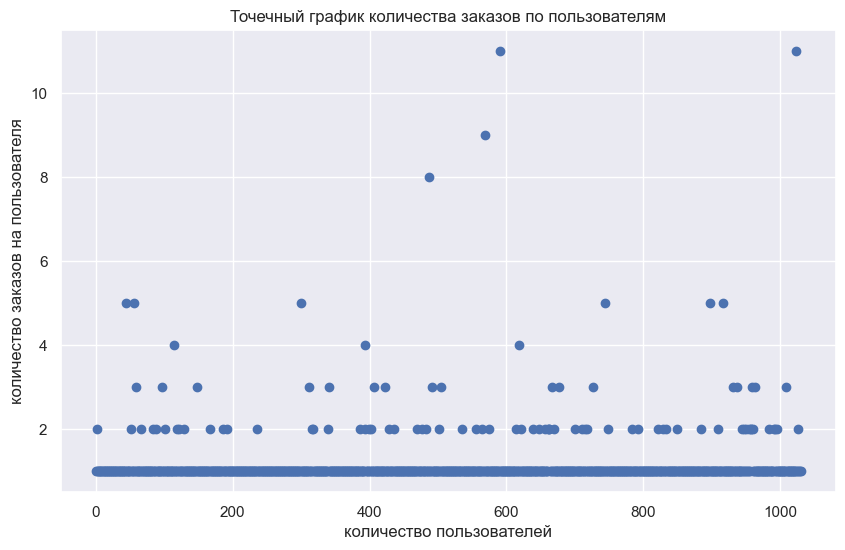

In [50]:
x_values = pd.Series(range(0,len(ordersByUsers['order_id'])))
plt.scatter(x_values, ordersByUsers['order_id'])
plt.xlabel('количество пользователей')
plt.ylabel('количество заказов на пользователя')
plt.title('Точечный график количества заказов по пользователям');

**Есть пользователи, которые совершили 4 заказа и более. Оказывается, в тесте учитываются данные тех, кто совершил 8, 9 и 11 заказов.Их пользовательское поведение выходит из общей тенденции, но  в силу крупных покупок влияет на общую картину при трактовании результатов A/B-теста.**

### Расчет перцентелей количества заказов 

**Не более 5% пользователей совершили 2 заказа. Также 4 заказа было оформлено не более 1% пользователей. Установим, что аномально поведение лишь 1% пользователей.В таком случае верхней границей будут 3 заказа на одного пользователя. Так мы избежим  риска отсеить слишком много заказов.**


In [51]:
np.percentile(ordersByUsers['order_id'], [95, 99])

array([2., 4.])

### Точечный график стоимостей заказов

**Сначала построим гистограмму.**

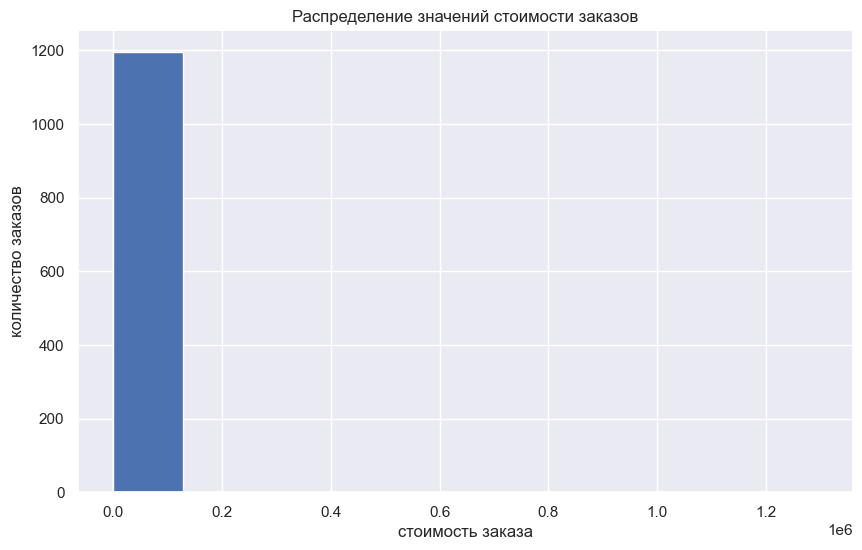

In [52]:
plt.hist(orders['revenue'])
plt.title('Распределение значений стоимости заказов')
plt.xlabel('стоимость заказа')
plt.ylabel('количество заказов');

**У подавляющего большинства заказаов стоимость доходит до 1200 рублей. Гистограмма не достаточно информативна, поэтому построим точечный график.**

**Максимальная стоимость заказа составляет около 1 млн 300 тыс. рублей.**

In [53]:
orders.revenue.max()

1294500

**А минимальная - 50 рублей.**

In [54]:
orders.revenue.min()

50

**Отсортируем значения стоимости заказов по убыванию, чтобы проверить, много ли в группах заказов с общей суммой более 1 млн. рублей. Как видно ниже, такой заказ лишь один. Также сумма лишь одного заказа превысила 100 тыс. рублей.**

In [55]:
orders.sort_values(by='revenue',ascending=False).head(10)

,order_id,user_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


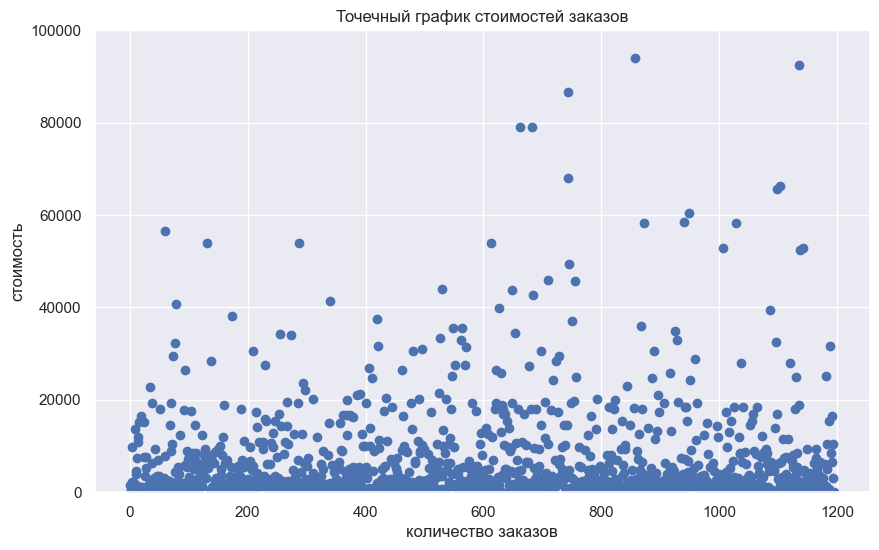

In [56]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)
plt.xlabel('количество заказов')
plt.ylabel('стоимость')
plt.title('Точечный график стоимостей заказов');

**У большинства заказов стоимость не превышает 20 тыс.рублей. Заказов со стоимостью от 20 до 40 тыс. рублей немало, но нужно проверить, важны ли они для верной трактовки результатов теста.**

###  Расчет 95-го и 99-го перцентелей стоимости заказа

**Стоимость не более чем 5% заказов составляет 28 тыс. рублей. У не более чем 1% заказов стоимость составляет 58 тыс. 233 рубля. По аналогии с количеством заказов на посетителя установим верхнюю границу с опорой на расчет 99-го перцентиля. Если мы удалим все заказы со стоимомостью выше 28 тыс. рублей, мы очень сильно усечем данные. Поэтому после фильтрации маскимальная стоимость заказов будет составлять 58 тыс. 233 рублей.**

In [57]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по "сырым" данным

**Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. В случае, если пользователь не совершил заказ, будет стоять ноль.**

In [58]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders_total'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_dateA'].sum() - len(ordersByUsersA['orders_total'])
        
            ),
            name='orders'
        ),
    ],
    axis=0   
)




sampleB = pd.concat(
    [
        ordersByUsersB['orders_total'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_dateB'].sum() - len(ordersByUsersB['orders_total'])
            ),
            name='orders'
        ),
    ],
    axis=0   
)

**Сформулируем нулевую гипотезу следующим образом:"Статистически значимых различий в среднем количестве заказов на посетителя по сырым данным между группами нет". Альтернативная гипотеза тогда будет следующей:"Существуют статистически значимые различия по сырым данным в среднем количестве заказов на посетителя между группами".**

**P-значение, т.е. вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе, меньше уровня статистической значимости (5%). Значит мы отвергаем гипотезу об отсутствии статически значимых различий. Действительно, существуют значимые различия среднем количестве заказов. Принимаем альтернативную гипотезу.**

In [59]:
print('P-значение составляет:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

P-значение составляет: 0.017


**При этом мы видим, что группа B находится в выигрыше по среднему количеству заказов. Этот показатель у нее выше на 13.8% по сравнению с группой А.Таким образом, пользователи из группы B совершали повторную покупку реже, но число тех из них, кто заказ все-таки оформил, выше чем в группе A.**

In [60]:
print('Отношение среднего количества заказов на посетителя группы B к группе A:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Отношение среднего количества заказов на посетителя группы B к группе A: 0.138


### Расчет статистической значимости различий в среднем чеке между группами по "сырым" данным

**Сформулируем нулевую гипотезу следующим образом: "По сырым данным не существует статистической значимости различий в среднем чеке между группами по "сырым" данным". Альтернативная гипотезу: "По сырым данным существуют статистически значимые различия в среднем чеке между группами по "сырым" даннным.** 

**P-значение значительно больше 5%, т.е. уровня статистической значимости. Таким образом, мы не отвергаем гипотезу об отсутствии статистической значимости различий в среднем чеке между группами по "сырыми" данными.**

In [61]:
print('P-значение составляет:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

P-значение составляет: 0.729


**Впрочем, средний чек среди в группе B на четверть выше, чем в группе A. Столь большая разница может быть связана с оформлением крупных заказов в середине августа.**

In [62]:
print('Отношение среднего чека в группе B к группе A:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
     

Отношение среднего чека в группе B к группе A: 0.259


**Очистим данные от аномалий и посмотрим, как изменится статистическая значимость.**

**Объявим переменные users_many_orders и users_expensive_orders, а затем объединим их  в переменную abnormal_users, чтобы узнать количество пользователей c числом заказов и суммой заказа, превышающие значения, полученные после расчет 99-го перцентиля.**

**Всего 16 пользователей с аномальным поведением.**

In [63]:
users_many_orders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders_total'] > np.percentile(ordersByUsers['order_id'], 99)]['user_id'],
        ordersByUsersB[ordersByUsersB['orders_total'] > np.percentile(ordersByUsers['order_id'], 99)]['user_id'],
    ],
    axis=0,
)
users_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'],99)]['user_id']

abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295 
949     887908475 
744     888512513 
1103    1164614297
1136    1307669133
Name: user_id, dtype: int64
15


**Построим графики по "очищенным" данным.**

In [64]:
orders = orders[~orders['user_id'].isin(abnormal_users)]  #удалим из датафрейма orders пользователей с аномальным поведением
  

**Повторим код с созданием датафреймов ordersAggregated visitorsAggregated. Это нужно, чтобы в датафрейме cumulative_data были отфильтрованные данные.**

In [65]:
ordersAggregated = datesGroups.apply( 
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'order_id': 'nunique',
            'user_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
          'date':'max',
        'group':'max',
        'visitors':'sum'      
        }
    ),
    axis=1,
).sort_values(by=['date','group'])

cumulative_data = ordersAggregated.merge(visitorsAggregated, right_on=['date','group'], left_on=['date','group'])

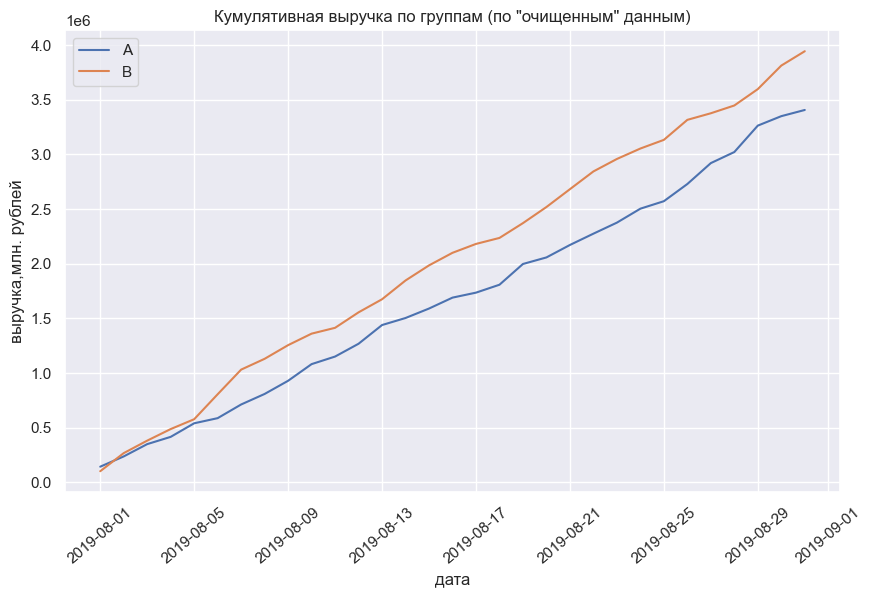

In [66]:
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'order_id']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'order_id']]

# Строим график выручки группы А
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('выручка,млн. рублей')
plt.title('Кумулятивная выручка по группам (по "очищенным" данным)');

**Выручка росла стабильно. Группа B выигрывает.**

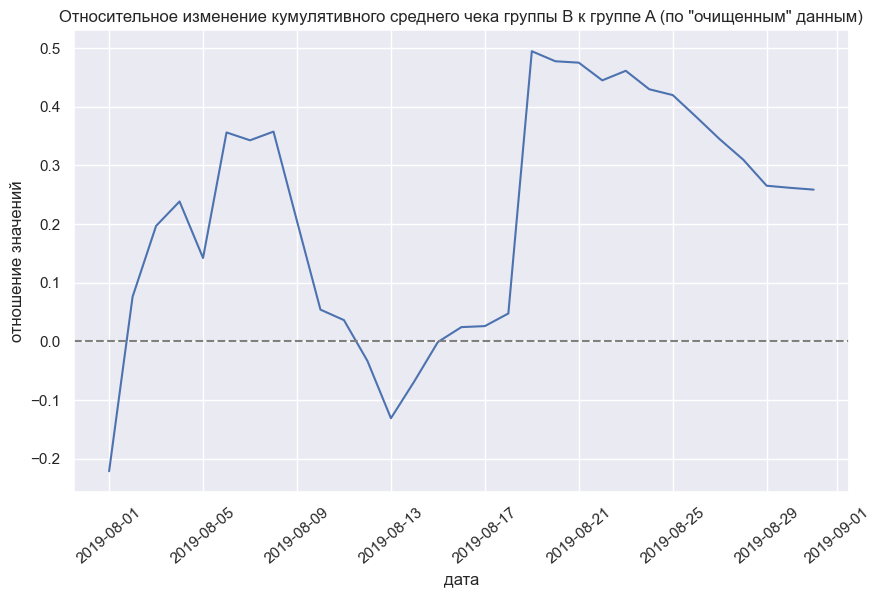

In [67]:
plt.plot(merged_сumulative_revenue['date'], (merged_сumulative_revenue['revenue_totalB'] /merged_сumulative_revenue['order_countB'])/(merged_сumulative_revenue['revenue_totalA']/merged_сumulative_revenue['order_countA'])-1)

plt.axhline(y=0,color='grey', linestyle='--')
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('отношение значений')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A (по "очищенным" данным)');

**После фильтрации данных график относительного изменения кумулятивного чека группы B к группе A по "очищенным" данным не изменился.**

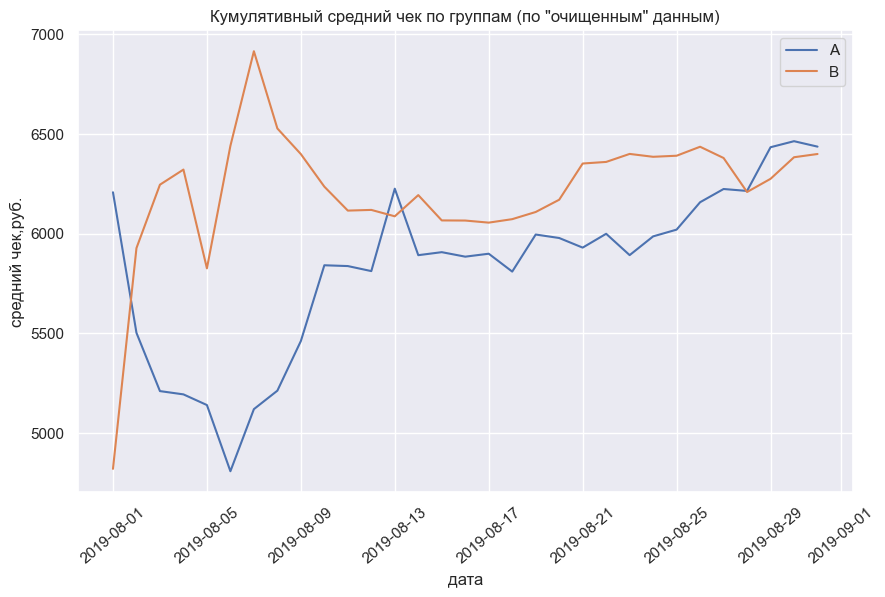

In [68]:
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['order_id'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['order_id'], label='B')
plt.legend()
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('средний чек,руб.')
plt.title('Кумулятивный средний чек по группам (по "очищенным" данным)');

**В самые первые дни теста кумулятивный средний чек в группе A был выше, чем в группе B.  13 августа средний чек в группе A также был выше, чемв  группе B. В остальные дни показатель был выше в группе В.**

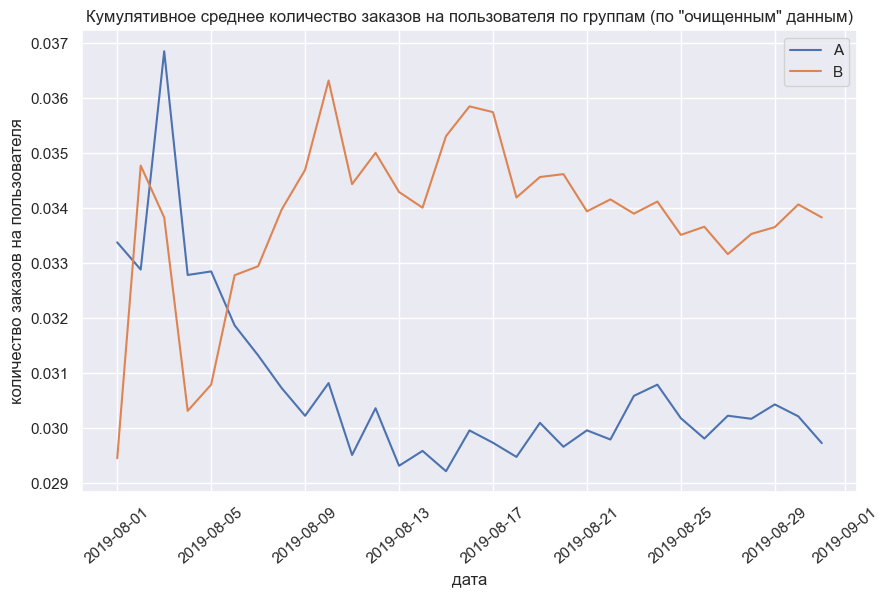

In [69]:
plt.plot(cumulative_dataA['date'], cumulative_dataA['order_count_per_user'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['order_count_per_user'], label='B')
plt.legend()
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('количество заказов на пользователя')
plt.title('Кумулятивное среднее количество заказов на пользователя по группам (по "очищенным" данным)');

**В начале теста группа A лидировала, однако в начале второй недели вырвалась вперед группа B.**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


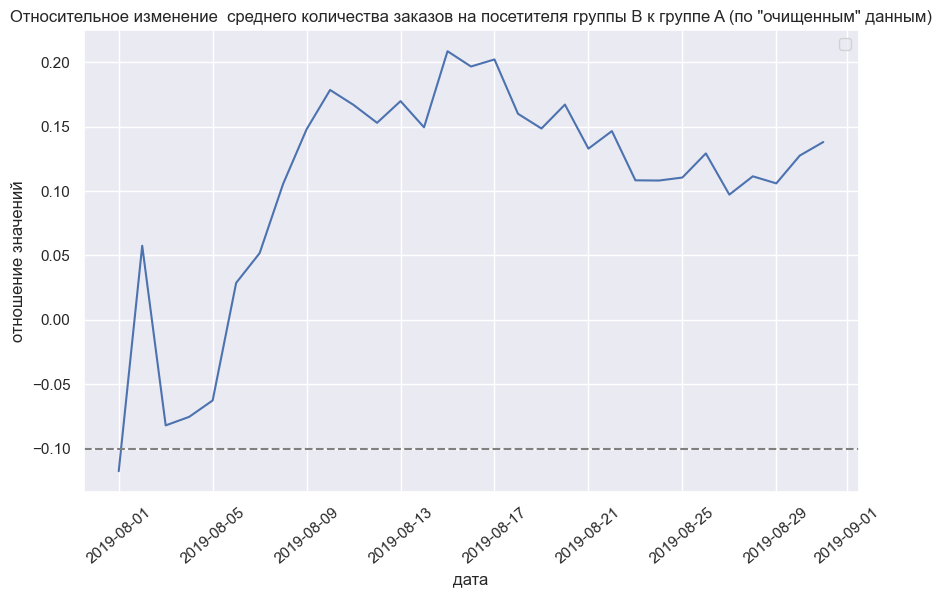

In [70]:
plt.plot(mergedOrderCountPerUser['date'], mergedOrderCountPerUser['order_count_per_userB']/mergedOrderCountPerUser['order_count_per_userA']-1)
plt.legend()
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation = 40) 
plt.xlabel('дата')
plt.ylabel('отношение значений')
plt.title('Относительное изменение  среднего количества заказов на посетителя группы B к группе A (по "очищенным" данным)');

**После фильтрации данных улучшились показатели среднего количества заказов на пользователя. Уверенное лидерство группы B.**

### 3.12 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным 

**Избавимся от аномалий.**

**Отфильтруем данные.**

In [71]:
sampleA_filtered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormal_users))
        ]['orders_total'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_dateA'].sum() - len(ordersByUsersA['orders_total'])
            ),
            name='orders_total',
        ),
    ],
    axis=0,
)



sampleB_filtered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormal_users))
        ]['orders_total'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_dateB'].sum() - len(ordersByUsersB['orders_total'])
            ),
            name='orders_total',
        ),
    ],
    axis=0,
)

**После фильтрации данных можно провести тест Манни-Уитни, чтобы увидеть статистическую значимость различий в среднем количестве заказов на посетителя по отфильтрованным данным.**

**Проверим  по отфильтрованным данным гипотезу нулевую гипотезу "Статистически значимых различий по отфильтрованным в среднем количестве заказов на посетителя между группами нет". Альтернативной является гипотеза тогда будет "Существуют статистически значимые различия по отфильтрованным в среднем количестве заказов на посетителя между группами".**

**После фильтрации p-значение практически не изменилось. На 1,5 процетных пункта выросло отношение среднего количества заказов на посетителя группы B к группе А. По этому критерию нововедение эффективно.**

In [72]:
print('P-значение после фильтрации:','{0:.3f}'.format(st.mannwhitneyu(sampleA_filtered,sampleB_filtered)[1]))

P-значение после фильтрации: 0.014


In [73]:
print('Отношение среднего количества заказов по отфильтрованным данным на посетителя группы B к группе А:', '{0:.3f}'.format(sampleB_filtered.mean() / sampleA_filtered.mean() - 1))

Отношение среднего количества заказов по отфильтрованным данным на посетителя группы B к группе А: 0.153


### Расчет статистической значимостм различий в среднем чеке заказа между группами по «очищенным» данным

**Сформулируем нулевую гипотезу:"После фильтрации данных отсутствует статистическая значимость различий в среднем чеке заказа между группами". Альтернативной будет: "После фильтрации есть статистически значимые различия в среднем чеке заказа между группами".**

**После фильтрации p-значение увеличилось. Сохраняем нулевую гипотезу: по отфильтрованным данным отсутствует статистическая значимость различий в среднем чеке заказа между группами.** 

In [74]:
print('P-значение после фильтрации:',
      '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
     )
    

P-значение после фильтрации: 0.851


**А отношение стало отрицательным. Группа B стала проигрывать по среднему чеку. Это относительное отклонение  величины  среднего чека в группе B от его величины в группе А не очень большое, однако оно имеется. Можно сделать вывод  о том, что на в группе B было сделано много дорогостоящих заказов.** 

In [75]:
print('Отношение среднего чека группы B к группе А после фильтрации:',
      '{0:.3f}'.format(
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['user_id'].isin(abnormal_users)),
        )
    ] ['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['user_id'].isin(abnormal_users)),
        )
    ] ['revenue'].mean()
    -1
)
     )

Отношение среднего чека группы B к группе А после фильтрации: -0.006


### Результаты A/B-теста

**Акумулируем выводы:**

    -Существует статистическая значимость различий среднего количества заказов на пользователя между группами как по сырым, так и отфильтрованным данным.
    -Нет статистической значимости различий среднего чека заказов между группами A и B как по сырым, так и отфильтрованным данным.
    -График различия среднего чека колеблется. Поскольку отношение было отрицательным на протяжении нескольких дней, нельзя сделать точных выводов по графику несмотря на то, что далее у группы B было преимущество.После фильтрации был получен отрицательный показатель отношения среднего чека в группе B к группе A, однако поскольку отсутствует статистически значимое различие между средними чеками групп как до, так и после фильтрации и сама разница составляет 0.6 процентных пункта, нельзя утверждать о проигрыше группы B.

##  Заключение

**Для того, чтобы выработать стратегию повышения выручки интернет-магазина в исследовании были предприняты следующие шаги:**
    
    -Проведение предобработку данных для повышения качества исследования;
    -Приоритизация гипотез по увеличению выручки с использованием различных фреймоворков (ICE и RICE);
    -Расчет кумулятивных пользовательских метрик по группам, в частности среднего чека, средней выручки и среднего 
     количества заказов;
    -Построение графиков кумулятивных пользовательских метрик;
    -Построение графиков отношения кумулятивных пользовательских метрик группы B к группе A;
    -Расчет статистической значимости различий средних пользовательских метрик (среднего чека, средней выручки и
    среднего     количества заказов) до исследования аномалий;
    -Выявление аномальных значений при помощи гистограмм и точечных графиков;
    -Расчет 95-го и 99-го перцентиля количества заказов на пользователя и стоимости заказов;
    -Очищение данных от аномалий;
    -Построение графиков кумулятивных пользовательских метрик после фильтрации данных;
    -Вычисление статистической значимости различий средних показателей пользовательского поведения после фильтрации 
    данных для того, чтобы оценить степень успешности A/B-теста.
    
После применения фрейоврки ICE и RICE удвлось установить наиболее приоритетные для проверки гипотезы. При выборе гипотез отдавалось предпочтение фреймворку RICE, поскольку тот учитывает охват нововведения. Несмотря на то, что у гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" двукратный отрыв, в качестве проверяемое гипотезы была выбрана та, которая занимает второе место - "добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". Такой выбор объясняется тем, что первая гипотеза не связана с вопросами повышения выручки, в то время как выбранная - как раз и направлена на выработку стратегий увеличения прибыли.

В ходе построения графиков кумулятивных средних значений пользовательских метрик (выручка по группам, средний чек по группам и среднее количество заказов по группам) было выявлено, что в анализе учитываются пользователи, чье потребительское поведение можно рассматривать как аномалию: оформление заказов на крупную сумму или оформление большого количества заказов.

Несмотря на то, что после фильтрации данных было получено отрицательное значение отношения среднего чека группы B к среднему чеку А, принято решение посчитать тест успешным и завершить его. На протяжении анализа выявлялось уверенное лидерство группы B: по некоторым метрикам отрыв от группы А был существенным, а отставание от группы А по среднему чеку состаявлет 0.6 процентных пункта. В связи с этим тест считается успешным, и рекомендуется его завершить.

